Model variation with residual connections

In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import tensorboard
from PIL import Image
import os
from datetime import datetime
from skimage.color import rgb2lab, rgb2gray, lab2rgb
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import pickle
from keras.layers import Dense, Conv2D, Reshape, GlobalAveragePooling2D, MaxPooling2D, UpSampling2D, Flatten

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


In [3]:
from data_processing import processing

train_data, test_data, class_names = processing("data/ColorfulOriginal/")

Found 721 files belonging to 20 classes.
Using 649 files for training.
Using 72 files for validation.
classes:  ['Apple', 'Banana', 'Brinjal', 'Broccoli', 'CapsicumGreen', 'Carrot', 'Cherry', 'ChilliGreen', 'Corn', 'Cucumber', 'LadyFinger', 'Lemon', 'Orange', 'Peach', 'Pear', 'Plum', 'Pomegranate', 'Potato', 'Strawberry', 'Tomato']
data example:  <PrefetchDataset element_spec=((TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 2), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 20), dtype=tf.int32, name=None))>


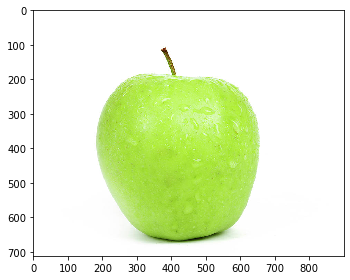

In [4]:
sample_image = imread("data/ColorfulOriginal/Apple/Apple1.jpg")/255
imshow(sample_image)

In [5]:
# check if images have same min and max values
sample_image = tf.convert_to_tensor(sample_image, dtype=tf.float32)
sample_image = tfio.experimental.color.rgb_to_lab(sample_image)

print(tf.reduce_min(sample_image[0]), tf.reduce_max(sample_image[0]))
print(tf.reduce_min(sample_image[1]), tf.reduce_max(sample_image[1]))
print(tf.reduce_min(sample_image[2]), tf.reduce_max(sample_image[2]))

tf.Tensor(-0.0024437904, shape=(), dtype=float32) tf.Tensor(100.0, shape=(), dtype=float32)
tf.Tensor(-0.0024437904, shape=(), dtype=float32) tf.Tensor(100.0, shape=(), dtype=float32)
tf.Tensor(-0.0024437904, shape=(), dtype=float32) tf.Tensor(100.0, shape=(), dtype=float32)


In [6]:
from Models import Only_Colorization_Model, Only_Classification_Model, Model
from Visualization import visualize
from Training import training_loop, training_loop_classification, training_loop_colorization

In [7]:
# train and test multi-task model
epochs = 500
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_function_color = tf.keras.losses.MeanSquaredError()
loss_function_category = tf.keras.losses.CategoricalCrossentropy()

model00001= Model(optimizer=optimizer, loss_function_color=loss_function_color, loss_function_category=loss_function_category)

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{current_time}"
train_log_path = f"logs/{current_time}/colorful/model_BN_DO_GA/Adam0.00001/train"
test_log_path = f"logs/{current_time}/colorful/model_BN_DO_GA/Adam0.00001/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)

training_loop(model00001, train_data, test_data, epochs, train_summary_writer, test_summary_writer, save_path)


 15%|███████████▋                                                                    | 6/41 [44:39<4:20:30, 446.58s/it]


KeyboardInterrupt: 

 20%|████████████████▊                                                                   | 1/5 [01:02<04:10, 62.56s/it]

CapsicumGreen Tomato


 40%|█████████████████████████████████▌                                                  | 2/5 [02:02<03:02, 60.95s/it]

CapsicumGreen Strawberry


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:10<02:08, 64.31s/it]

CapsicumGreen Strawberry


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:08<01:01, 61.91s/it]

CapsicumGreen Strawberry


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:42<00:00, 56.41s/it]

CapsicumGreen Tomato


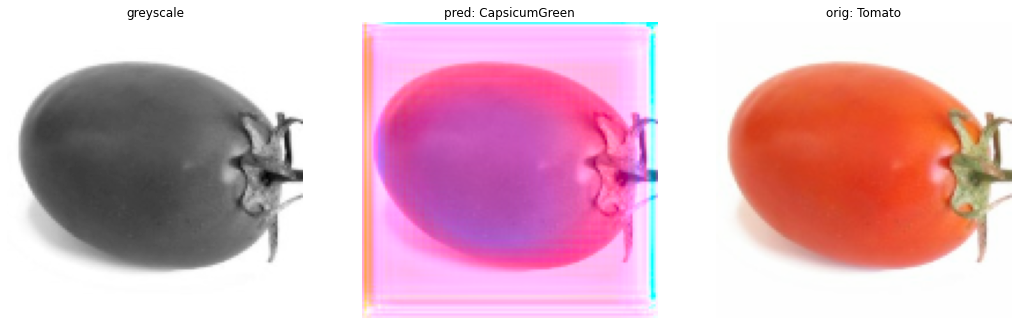

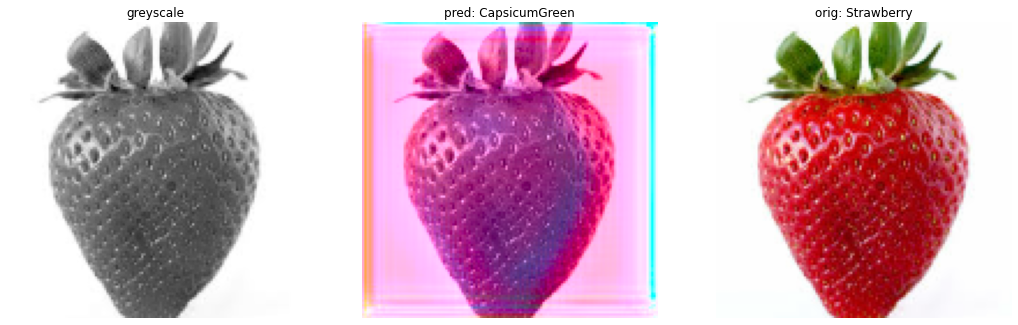

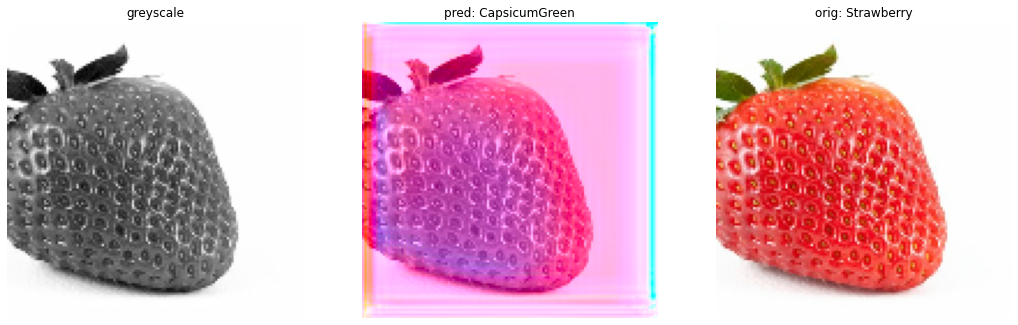

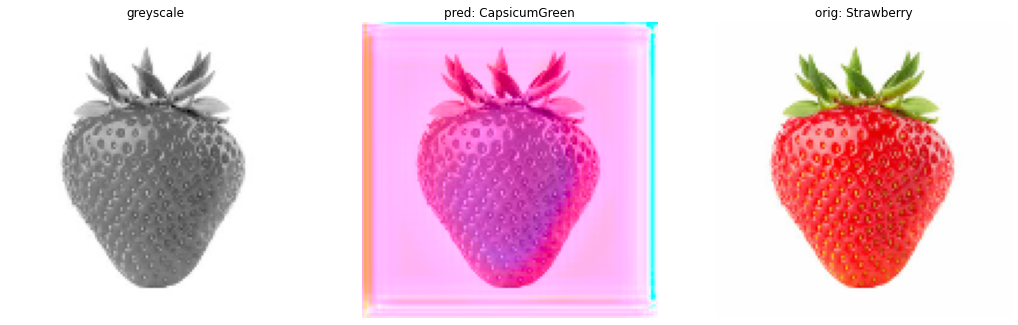

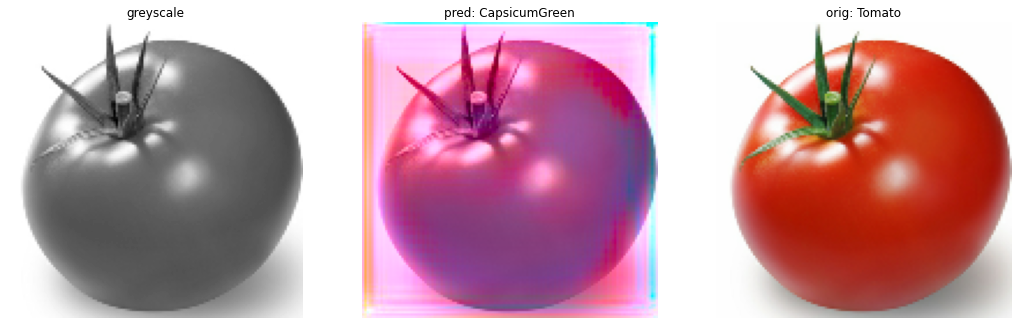

In [8]:
# visualize data examples with predicted and true colorization
for data in tqdm(test_data, position=0, leave=True):
    predicted_color, predicted_label = model00001.test_step(data)

    if random.random() < 1:
        visualize(predicted_color[0], predicted_label[0], data, class_names)


In [ ]:
# train and test single-task classification model
epochs = 500
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_function_color = tf.keras.losses.MeanSquaredError()
loss_function_category = tf.keras.losses.CategoricalCrossentropy()

only_classification = Only_Classification_Model(optimizer=optimizer, loss_function_category=loss_function_category)

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{current_time}"
train_log_path = f"logs/classification/colorful/{current_time}/0.00001/train"
test_log_path = f"logs/classification/colorful/{current_time}/0.00001/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop_classification(only_classification, train_data, test_data, epochs, train_summary_writer, test_summary_writer, save_path)

In [ ]:
# train and test single-task colorization model
epochs = 500
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_function_color = tf.keras.losses.MeanSquaredError()
loss_function_category = tf.keras.losses.CategoricalCrossentropy()

only_colorization = Only_Colorization_Model(optimizer=optimizer, loss_function_color=loss_function_color)

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{current_time}"
train_log_path = f"logs/colorization/colorful/{current_time}/0.00001/train"
test_log_path = f"logs/colorization/colorful/{current_time}/0.00001/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)

training_loop_colorization(only_colorization, train_data, test_data, epochs, train_summary_writer, test_summary_writer, save_path)


In [ ]:
# visualize data examples with predicted and true colorization
for data in tqdm(test_data, position=0, leave=True):
    predicted_color = only_colorization.test_step(data)

    if random.random() < 1:
        visualize(predicted_color[0], data[1][0], data)